# Restoring gold from ore

## Project Description

We will prepare a prototype of machine learning model for “numbers”. The company is developing solutions for the effective operation of industrial enterprises.
The model should predict the coefficient of restoration of gold from gold-containing ore. At our disposal, data with production and cleaning parameters.
The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

We need:
- prepare data;
- conduct a research analysis of data;
- Build and train the model.

The technological process of mining from ore. We will carefully study the stages of the process.

When the mined ore undergoes primary processing, the crushed mixture is obtained.It is sent to flotation (enrichment) and two-stage cleaning.

<img src="img/stages_of_processing.jpg"
     alt="Stages of processing"
     width="800"
    >

We describe each stage:
1. Flotation
A mixture of gold -containing ore is supplied to the flotation installation.After enrichment, a black concentrate and “dump tails” are obtained, that is, the remains of a product with a low concentration of valuable metals.
The stability of this process is affected by the unstable and non-optimal physico-chemical state of the flotation pulp (a mixture of solid particles and liquid).
2. Cleaning
Black concentrate passes two cleaning.The output is final concentrate and new dump tails.

Data description

Process
- `Rougher feed` - The starting raw material
- `Rougher Additions` (or `reagent additions`) - Flotation reagents: `Xanthate`, `Sulphate`, `Depressant`
  - `Xanthate` ** - xanthogenate (promoter, or flotation activator);
  - `Sulphate` - sulfate (in this production of sodium sulfide);
  - `Depressant` - Depressant (sodium silicate).
- `Rougher process` (English" rude process ") - flotation
- `Rougher Tails' - Dumped tails
- `Float banks` - Flotation installation
- `Cleaner process` - Cleaning
- `Rougher au` - black gold concentrate
- `Final au` - final gold concentrate

Parameters of stages
- `air amount` - Air volume
- `fluid levels` - fluid level
- `fed size` - the size of granules of raw materials
- `fed rate` - feed speed

### Features

The name of features should be like this:
`[stage].[feature_type].[feature_name]`

Example: `rogher.input.feed_ag`

Possible values ​​for the block [stage]:
- `rogher` - flotation
- `primary_cleaner` - primary cleaning
- `secondary_cleaner` - secondary cleaning
- `final` - final characteristics

Possible values ​​for the block [feature_type]:
- `input` - raw materials parameters
- `output` - product parameters
- `state` - parameters characterizing the current state of the stage
- `calculation` - calculated characteristics

### Calculation of efficiency

We need to simulate the process of restoring gold from gold-containing ore.

The effectiveness of enrichment is calculated by the formula:

$$ Recovery = \frac{C * (F - T)}{F * (C - T)} $$

Where:
- `C` - the share of gold in the concentrate after flotation/cleaning;
- `F` - the share of gold in raw materials/concentrate to flotation/cleaning;
- `T` - the share of gold in the dash tails after flotation/cleaning.

### The metric of quality

To solve the problem, we introduce a new quality metric - `sMAPE` (Symmetric Mean Absolute Percentage Error).
It is similar to `MAE`, but it is not expressed in absolute values, but in relative ones.Why symmetric?It equally takes into account the scale of both the target feature and predictions.
Smape metric is calculated as follows:

$$ {sMAPE} = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} * 100\% $$

Designations:

- $y_i$ the value of the target feature for an object with serial number I in the sample on which quality is measured.

- $\hat{y_i}$ the value of prediction for an object with ordinal number I, for example, in a test sample.

- $N$ the number of objects in the sample.

- $\sum_{i=1}^{N}$ Summing for all sampling objects (I changes from 1 to N).

It is necessary to predict two values ​​at once:
- the effectiveness of the enrichment of the draft concentrate `rougher.output.recovery`;
- The effectiveness of enrichment of the final concentrate `final.output.recovery`.

The final metric consists of two quantities:

$$ {sMAPE} = 25\% * {sMAPE(rougher)}  + 75\% * {sMAPE(final)}  $$

Data are in three files:
- `gold_recovery_train_new.csv` - training sample;
- `gold_recovery_test_new.csv` - test sample;
- `gold_recovery_full_new.csv` - initial data.

Data is indexed by the date and time of receipt of information (feature `"Date"`).Time neighboring parameters are often similar.

Some parameters are not available, because they are measured and/or calculated much later. Because of this, there are no signs in the test sample that may be in the training.There are also no targeted signs in the test set.

The initial dataset contains training and test samples with all the signs.
Raw data at our disposal: they were simply unloaded from the storage. Before proceeding with the construction of the model, we will check them according to our instructions for correctness.

- 1. Prepare data
    - 1.1. Open the files and study them.
        - Path to files:
        - `/datasets/gold_recovery_train_new.csv.` [download Dataset](https://code.s3.s3.yandex.net/datasets/gold_recovery_train_new.csv "gold_recovery_train_new.csv")
        - `/datasets/gold_recovery_test_new.csv.` [download Dataset](https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv" "gold_recovery_test_new.csv")
        - `/datasets/gold_recovery_full_new.csv.` [download Dataset](https://code.s3.s3.yandex.net/datasets/gold_recovery_full_new.csv "gold_recovery_full_new.csv")
    - 1.2. We check that the effectiveness of enrichment is calculated correctly.We calculate it on the training sample for a sign `rougher.output.recovery`. Find `MAE` between your calculations and the value of the sign.We describe the conclusions.
    - 1.3. Let us analyze the signs inaccessible in the test sample.
    - 1.4. We will exploit data.
- 2. We analyze the data
    - 2.1. Let's see how the concentration of metals (Au, Ag, Pb) changes at various stages of cleaning.Opening conclusions.
    - 2.2. Compare the distribution of the size of the granules of raw materials in the training and test samples. (If the distributions are very different from each other, the evaluation of the model will be wrong).
    - 2.3. We examine the total concentration of all substances at different stages: in raw materials, in draft and final concentrates.
- 3. We will build a model
    - 3.1. We will write a function for calculating the final `sMAPE`.
    - 3.2. We will train different models and evaluate their quality cross-nineteration.We choose the best model and check it in a test sample.We describe the conclusions.

## Data Preparation

### Loading and Inspection

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os.path
import math
 
import chart_studio
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(world_readable=True, theme='henanigans', offline=True)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

### Import datasets using the try/except method and set the index to the date column

In [2]:
try:
    path_train = os.path.join('datasets/gold_recovery_train_new.csv', index_col='date')
    train = pd.read_csv(path_train)
except:
    train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv', index_col='date')

train = train.set_index(pd.DatetimeIndex(train.index))

try:
    path_test = os.path.join('datasets/gold_recovery_test_new.csv', index_col='date')
    test = pd.read_csv(path_test)
except:
    test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv', index_col='date')

test = test.set_index(pd.DatetimeIndex(test.index))

try:
    path_full = os.path.join('datasets/gold_recovery_full_new.csv', index_col='date')
    full = pd.read_csv(path_full)
except:
    full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv', index_col='date')

full = full.set_index(pd.DatetimeIndex(full.index))

### Let's look at the data

In [3]:
def first_view(data):
    title_lenght = 79
    title_one = 'Overview of the data of the first and last five rows'
    print('~' * int((title_lenght - len(title_one)) / 2), title_one, '~' * (title_lenght - len(title_one) - int((title_lenght - len(title_one)) / 2)))
    display(data.head(5))
    display(data.tail(5))
    print()
    title_two = 'General describe info'
    print('~' * int((title_lenght - len(title_two)) / 2), title_two, '~' * (title_lenght - len(title_two) - int((title_lenght - len(title_two)) / 2)))
    display(data.describe())
    print()
    title_three = 'Data type' 
    print('~' * int((title_lenght - len(title_three)) / 2), title_three, '~' * (title_lenght - len(title_three) - int((title_lenght - len(title_three)) / 2)))
    data.info()
    print()
    title_four = 'Missings'
    print('~' * int((title_lenght - len(title_four)) / 2), title_four, '~' * (title_lenght - len(title_four) - int((title_lenght - len(title_four)) / 2)))
    all_nulls = 0
    for col in data.columns:
       if data[col].isna().sum() > 0:
            all_nulls += 1
            print(f"{data[col].isna().sum()} missing values ​​in the column {col}. it's {round(data[col].isna().mean() * 100, 2)}%")
    if all_nulls == 0:
        print('There are no gaps in the data frame')
    print()
    title_five = 'Obvious duplicates'
    print('~' * int((title_lenght - len(title_five)) / 2), title_five, '~' * (title_lenght - len(title_five) - int((title_lenght - len(title_five)) / 2)))
    if data.duplicated().sum() > 0:
        print('Count of obvious duplicates - ', data.duplicated().sum())
    else:
        print('There is no Obvious duplicates in data frame')
    print()

In [4]:
datasets = {'Train set': train, 'Test set': test, 'Full set': full}

for name, dataset in datasets.items():
    print('***', name, '***')
    first_view(dataset)
    print()

*** Train set ***
~~~~~~~~~~~~~ Overview of the data of the first and last five rows ~~~~~~~~~~~~~~


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,1549.78,-498.91,1551.43,-516.40,1549.87,-498.67,1554.37,-493.43,41885.71,3481.78,3520.34,2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,1603.01,-434.72,1602.38,-442.20,1598.94,-451.29,1404.47,-455.46,1416.35,-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,1576.17,-500.90,1575.95,-499.87,1575.99,-499.32,1574.48,-498.93,42050.86,3498.37,3489.98,2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,1000.29,-400.07,1600.75,-449.95,1600.48,-449.83,1600.53,-449.95,1399.23,-4

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-18 06:59:59,3.22,11.36,6.80,46.71,73.76,8.77,3.14,10.40,1.53,123.38,8.03,6.50,1.30,6.56,12.45,7.06,32.94,22.85,6.53,3.93,2.31,1648.42,-400.38,1648.74,-400.36,1648.58,-399.36,1648.83,-399.67,45912.94,2497.65,2499.18,1.16,6.09,4.62,560.89,85.72,37.37,5.34,7.76,9.16,7.77,9.16,11.12,10.98,30.07,18.60,89.57,4.21,0.61,16.67,0.75,1199.25,-300.85,1149.81,-498.79,1047.96,-498.41,946.64,-499.15,849.66,-499.21,849.76,-497.45,0.00,0.00,0.00,0.00,35.04,-499.05,29.91,-499.98,26.00,-499.95,22.99,-499.97,23.03,-501.17,20.01,-499.74,18.01,-499.83,13.00,-500.16,20.01,-501.30
2018-08-18 07:59:59,3.20,11.35,6.86,46.87,69.05,8.90,3.13,10.55,1.61,120.88,7.96,6.50,1.30,6.61,12.62,7.54,32.93,23.00,6.63,4.09,2.46,1649.82,-399.93,1649.36,-399.72,1648.66,-401.20,1649.73,-400.64,46200.10,2614.40,2518.55,1.17,6.12,4.14,559.03,119.50,38.59,4.84,7.36,9.30,7.10,9.30,11.43,10.89,29.78,18.44,87.72,4.18,0.65,16.96,0.77,1196.57,-299.51,1147.68,-500.61,1048.57,-500.93,949.77,-500.02,848.52,-500.29,85


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ General describe info ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.00,14148.00,13938.00,14149.00,14149.00,14149.00,14049.00,14144.00,14149.00,14129.00,14117.00,14149.00,14049.00,14149.00,14063.00,13863.00,14149.00,14148.00,14134.00,14103.00,14149.00,14145.00,14148.00,14145.00,14148.00,14147.00,14148.00,14146.00,14148.00,14148.00,14148.00,14148.00,14149.00,14149.00,14049.00,14141.00,14005.00,14071.00,14149.00,14120.00,14141.00,14113.00,13721.00,14149.00,14149.00,14127.00,14149.00,14149.00,14148.00,14149.00,14149.00,14149.00,14148.00,14148.00,14148.00,14148.00,14148.00,14148.00,14149.00,14149.00,13713.00,14149.00,14149.00,14149.00,14147.00,14139.00,12544.00,14149.00,13932.00,14148.00,14128.00,14148.00,14145.00,14148.00,14148.00,14148.00,14143.00,14148.00,14148.00,14148.00,14148.00,14148.00,14148.00,14148.00,14147.00,14148.00
mean,5.14,10.13,9.20,44.00,66.52,9.61,2.60,10.51,2.92,133.32,8.87,7.32,0.89,8.20,9.59,10.11,32.39,16.30,3.44,7.53,3.84,1608.00,-488.78,1608.61,-489.17,1608.88,-489.61,1542.19,-483.46,40382.65,3456.61,3253.36,2.37,8.58,3.52,474.03,60.11,36.31,7.87,11.76,5.85,11.37,5.89,11.78,7.66,28.30,19.44,82.70


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Data type ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                  

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.80,14.99,8.08,1.01,1398.98,-500.23,1399.14,-499.92,1400.10,-500.70,1399.00,-499.49,13.13,5.64,489.79,62.71,42.02,12.08,16.92,6.15,16.87,6.15,1001.85,-350.30,1249.74,-399.11,1249.75,-399.40,1198.29,-399.49,999.47,-399.53,949.57,-398.18,24.94,-500.49,14.95,-500.01,20.02,-450.40,13.99,-449.83,12.02,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71
2016-09-01 01:59:59,215.39,14.99,8.08,0.99,1398.78,-500.06,1398.06,-499.78,1396.15,-499.24,1399.51,-500.42,13.04,5.53,490.10,61.96,41.19,11.92,17.00,6.00,17.00,6.00,998.69,-350.43,1248.40,-399.95,1249.51,-399.63,1200.51,-399.94,1000.00,-399.49,950.20,-405.79,24.92,-499.81,14.93,-500.76,19.99,-450.11,14.09,-450.06,12.06,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82
2016-09-01 02:59:59,215.26,12.88,7.79,1.00,1398.49,-500.87,1398.86,-499.76,1398.08,-502.15,1399.50,-499.72,13.14,5.43,489.62,66.90,42.55,12.09,16.99,5.85,16.98,5.85,998.52,-349.78,1247.44,-400.26,1248.21,-401.07,1199.77,-400.79,999.93,-399.24,950.32,-400.86,24.91,-500.30,15.00,-500.99,20.04,-450.26,14.08,-449.66,11.96,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62
2016-09-01 03:59:59,215.34,12.01,7.64,0.86,1399.62,-498.86,1397.44,-499.21,1400.13,-498.36,1401.07,-501.04,12.40,5.11,476.62,59.87,41.06,12.18,16.53,5.80,16.52,5.80,1000.28,-350.17,1251.32,-398.66,1250.49,-399.75,1199.40,-397.50,1001.93,-400.44,950.74,-399.80,24.89,-499.38,14.92,-499.86,20.03,-449.37,14.01,-449.53,12.03,-498.35,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71
2016-09-01 04:59:59,199.10,10.68,7.53,0.81,1401.27,-500.81,1398.13,-499.50,1402.17,-500.81,1399.48,-499.37,11.33,4.77,488.25,63.32,41.27,11.29,13.61,5.74,13.65,5.74,996.54,-350.56,1304.66,-399.51,1306.46,-399.05,1248.70,-400.88,1058.84,-398.99,949.65,-399.28,24.89,-499.36,14.98,-500.19,19.96,-450.64,14.01,-450.02,12.03,-500.79,8.05,-500.40,8.11,-509.53,4.96,-500.36,25.00,-500.86


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31 19:59:59,173.96,15.96,8.07,0.90,1401.93,-499.73,1401.44,-499.19,1399.81,-499.60,1400.33,-499.24,11.64,4.70,521.69,66.76,42.02,10.55,10.11,7.20,10.11,7.20,1399.94,-300.00,1049.64,-500.07,951.92,-499.65,852.34,-498.46,851.44,-500.29,851.46,-499.74,21.91,-499.92,19.91,-499.73,24.94,-500.10,12.97,-499.95,14.00,-500.16,12.07,-499.67,7.98,-499.52,5.93,-499.97,8.99,-499.76
2017-12-31 20:59:59,172.91,16.00,8.07,0.90,1447.08,-494.72,1448.85,-465.96,1443.89,-503.59,1447.65,-480.40,11.34,4.48,530.20,62.56,41.10,10.25,9.98,7.20,9.98,7.20,1406.12,-299.06,1055.72,-498.25,956.85,-497.40,855.39,-495.70,852.07,-499.44,851.33,-496.58,25.32,-497.03,23.31,-498.89,26.37,-499.22,17.70,-499.55,16.75,-496.03,13.37,-499.12,9.29,-496.89,7.37,-499.94,8.99,-499.90
2017-12-31 21:59:59,171.14,15.99,8.07,1.17,1498.84,-501.77,1499.57,-495.52,1502.75,-520.67,1502.59,-498.26,11.29,4.41,546.31,73.65,41.10,10.17,10.18,7.20,10.19,7.20,1396.20,-300.21,1047.88,-499.60,948.96,-499.55,856.33,-500.10,850.61,-499.47,850.28,-498.51,29.08,-500.53,26.89,-500.98,28.00,-500.57,23.00,-500.48,19.99,-499.79,15.10,-499.94,10.99,-498.35,9.02,-500.04,8.98,-497.79
2017-12-31 22:59:59,179.70,15.44,8.07,1.50,1498.47,-500.48,1497.99,-519.20,1496.57,-487.48,1502.69,-501.57,11.29,4.34,547.33,78.07,41.72,10.07,10.73,7.20,10.73,7.20,1403.94,-300.03,1049.80,-499.80,950.77,-500.37,847.65,-499.92,849.41,-500.38,850.08,-500.48,29.10,-499.69,27.05,-499.86,27.98,-499.91,23.05,-499.74,19.96,-499.96,15.03,-499.72,11.01,-499.99,9.01,-499.94,9.01,-500.15
2017-12-31 23:59:59,181.56,15.00,8.07,1.62,1498.10,-499.80,1501.74,-505.15,1499.54,-492.43,1499.67,-499.77,10.90,4.09,564.54,77.68,40.89,9.70,10.79,7.20,10.79,7.20,1400.61,-299.99,1052.78,-499.76,950.79,-499.36,850.64,-500.43,850.37,-500.82,850.68,-498.54,29.10,-500.43,26.89,-500.09,28.02,-500.17,23.01,-500.22,20.03,-500.73,14.91,-499.95,10.99,-500.66,8.99,-500.34,8.99,-500.76



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ General describe info ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.00,5285.00,5290.00,5286.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5287.00,5289.00,5269.00,5290.00,5285.00,5290.00,5282.00,5265.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5287.00,5290.00,5288.00,5290.00,5281.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00
mean,174.84,8.68,7.27,1.38,1539.49,-497.67,1545.17,-500.27,1527.27,-498.33,1544.84,-500.20,9.37,3.80,489.80,55.95,37.72,9.33,13.86,6.47,13.92,6.51,1053.40,-395.73,1318.93,-475.24,1301.60,-474.84,1214.85,-475.68,1056.65,-469.03,997.95,-470.48,26.31,-502.75,21.95,-501.99,25.40,-507.49,20.98,-506.63,16.32,-505.14,13.74,-463.35,12.80,-501.33,9.88,-495.66,17.30,-501.79
std,43.03,3.07,0.61,0.64,116.80,19.95,122.22,32.97,122.54,21.96,124.77,31.05,1.93,0.95,108.04,19.08,5.49,1.62,3.35,1.07,3.22,0.89,121.14,91.09,156.45,45.65,171.27,45.86,185.76,47.84,131.54,59.33,128.22,60.76,3.43,28.76,4.35,34.58,6.53,47.62,6.74,44.53,3.49,31.43,3.43,86.19,3.03,17.95,2.87,34.54,4.54,39.04
min,2.57,0.00,5.65,0.00,0.00,-795.32,0.00,-800.00,0.00,-799.96,0.00,-799.79,0.57,0.27,0.00,0.05,1.39,0.57,0.00,0.00,0.00,0.01,-0.04,-657.95,-0.72,-650.25,-0.06,-647.54,-0.99,-648.39,-1.98,-649.27,-2.59,-649.95,0.21,-784.09,0.01,-797.78,0.00,-799.76,0.00,-809.33,0.00,-799.80,0.00,-800.84,0.07,-797.32,0.53,-800.22,-0.08,-809.74
25%,147.12,6.49,6.89,0.91,1498.94,-500.36,1498.97,-500.70,1473.23,-501.02,1499.48,-500.45,8.11,3.24,407.02,43.91,34.51,8.21,12.00,6.00,12.00,6.00,999.21,-499.92,1200.87,-500.26,1199.65,-500.23,1093.37,-500.44,999.36,-500.19,901.02,-500.62,24.94,-500.21,20.00,-500.22,22.98,-500.30,17.97,-500.15,14.04,-500.87,12.03,-500.32,10.91,-500.73,8.04,-500.19,14.00,-500.69
50%,177.83,8.05,7.25,1.20,1585.13,-499.97,1595.62,-500.03,1549.59,-500.02,1594.58,-500.02,9.76,3.74,499.05,50.84,37.98,9.59,14.00,6.50,14.00,6.50,1000.47,-399.69,1302.25,-499.84,1300.20,-499.78,1207.01,-499.69,1047.50,-499.77,999.44,-499.68,26.91,-500.00,22.94,-500.02,25.01,-500.03,21.00,-500.01,17.01,-500.12,14.96,-499.58,12.95,-499.99


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Data type ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air 

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,1549.78,-498.91,1551.43,-516.40,1549.87,-498.67,1554.37,-493.43,41885.71,3481.78,3520.34,2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,1603.01,-434.72,1602.38,-442.20,1598.94,-451.29,1404.47,-455.46,1416.35,-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,1576.17,-500.90,1575.95,-499.87,1575.99,-499.32,1574.48,-498.93,42050.86,3498.37,3489.98,2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,1000.29,-400.07,1600.75,-449.95,1600.48,-449.83,1600.53,-449.95,1399.23,-4

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-18 06:59:59,3.22,11.36,6.80,46.71,73.76,8.77,3.14,10.40,1.53,123.38,8.03,6.50,1.30,6.56,12.45,7.06,32.94,22.85,6.53,3.93,2.31,1648.42,-400.38,1648.74,-400.36,1648.58,-399.36,1648.83,-399.67,45912.94,2497.65,2499.18,1.16,6.09,4.62,560.89,85.72,37.37,5.34,7.76,9.16,7.77,9.16,11.12,10.98,30.07,18.60,89.57,4.21,0.61,16.67,0.75,1199.25,-300.85,1149.81,-498.79,1047.96,-498.41,946.64,-499.15,849.66,-499.21,849.76,-497.45,0.00,0.00,0.00,0.00,35.04,-499.05,29.91,-499.98,26.00,-499.95,22.99,-499.97,23.03,-501.17,20.01,-499.74,18.01,-499.83,13.00,-500.16,20.01,-501.30
2018-08-18 07:59:59,3.20,11.35,6.86,46.87,69.05,8.90,3.13,10.55,1.61,120.88,7.96,6.50,1.30,6.61,12.62,7.54,32.93,23.00,6.63,4.09,2.46,1649.82,-399.93,1649.36,-399.72,1648.66,-401.20,1649.73,-400.64,46200.10,2614.40,2518.55,1.17,6.12,4.14,559.03,119.50,38.59,4.84,7.36,9.30,7.10,9.30,11.43,10.89,29.78,18.44,87.72,4.18,0.65,16.96,0.77,1196.57,-299.51,1147.68,-500.61,1048.57,-500.93,949.77,-500.02,848.52,-500.29,85


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ General describe info ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.00,19438.00,19228.00,19439.00,19439.00,19438.00,19338.00,19433.00,19439.00,19415.00,19402.00,19439.00,19335.00,19439.00,19323.00,19069.00,19439.00,19435.00,19418.00,19377.00,19439.00,19435.00,19438.00,19435.00,19438.00,19437.00,19438.00,19436.00,19438.00,19437.00,19437.00,19437.00,19439.00,19439.00,19339.00,19428.00,19294.00,19340.00,19439.00,19405.00,19431.00,19395.00,18986.00,19439.00,19439.00,19416.00,19439.00,19439.00,19438.00,19439.00,19439.00,19439.00,19438.00,19438.00,19438.00,19438.00,19438.00,19438.00,19439.00,19439.00,19003.00,19439.00,19439.00,19439.00,19437.00,19427.00,17691.00,19439.00,19219.00,19438.00,19416.00,19438.00,19426.00,19438.00,19438.00,19438.00,19433.00,19438.00,19438.00,19438.00,19438.00,19438.00,19438.00,19438.00,19437.00,19438.00
mean,5.17,9.98,9.50,44.08,67.05,9.69,2.71,10.58,3.04,144.62,8.82,7.31,1.02,8.44,9.83,10.49,32.12,16.15,3.44,7.97,3.91,1589.35,-491.20,1591.34,-492.19,1586.67,-491.98,1542.91,-488.02,42171.19,3393.05,3256.85,2.42,8.79,3.60,478.32,58.97,36.70,8.27,12.33,6.02,12.06,6.07,11.99,7.61,28.81,19.77,83.33,


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Data type ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                  

### Let's see the histograms

In [5]:
# # Uncomment this code line under this comment if you want to start this project locally and watch histograms interactivly
# # To analyze individual histograms for each column, double-click on the column name in the list on the right (if all are shown)
# # click on the next one (if one is shown) and click on the one you want to remove. So we analyze each one to the end.
# # I remove it from render before upload to GitHub, cus of 100mb files limit and add screenshots, so you can see the result of this code

# full.iplot(kind='hist', title='Histograms analysis', xTitle='Value', yTitle='Count')

<img src="img/final_output_concentratrate.png"
     alt="Final output concentratrate"
     width="1200"
    >

<img src="img/final_output_recovery.png"
     alt="Final output recovery"
     width="1200"
    >

<img src="img/final_output_tail.png"
     alt="Final output tail"
     width="1200"
    >

<img src="img/primary_cleaner_input.png"
     alt="Primary cleaner input"
     width="1200"
    >

<img src="img/primary_cleaner_output_concentrate.png"
     alt="Primary cleaner output concentrate"
     width="1200"
    >

<img src="img/primary_cleaner_output_tail.png"
     alt="Primary cleaner output tail"
     width="1200"
    >

<img src="img/primary_cleaner_state_floatbank8_air.png"
     alt="Primary cleaner state floatbank8 air"
     width="1200"
    >

<img src="img/primary_cleaner_state_floatbank8_level.png"
     alt="Primary cleaner state floatbank8 level"
     width="1200"
    >

<img src="img/rougher_calculation_au_pb_ratio.png"
     alt="Rougher calculation au pb ratio"
     width="1200"
    >

<img src="img/rougher_calculation_floatbanks10-11_sulfate_to_au.png"
     alt="Rougher calculation floatbanks10-11 sulfate to au"
     width="1200"
    >

<img src="img/rougher_calculation_sulfate_to_au_concentrate.png"
     alt="Rougher calculation sulfate to au concentrate"
     width="1200"
    >

<img src="img/rougher_input_feed_rate_n_size.png"
     alt="Rougher input feed rate n size"
     width="1200"
    >

<img src="img/rougher_input_feed_x.png"
     alt="Rougher input feed x"
     width="1200"
    >

<img src="img/rougher_input_floatbank10.png"
     alt="Rougher input floatbank10"
     width="1200"
    >

<img src="img/rougher_input_floatbank11.png"
     alt="Rougher input floatbank11"
     width="1200"
    >

<img src="img/rougher_output_concentrate.png"
     alt="Rougher output concentrate"
     width="1200"
    >

<img src="img/rougher_output_recovery.png"
     alt="Rougher output recovery"
     width="1200"
    >

<img src="img/rougher_output_tail.png"
     alt="Rougher output tail"
     width="1200"
    >

<img src="img/rougher_state_floatbank10_air.png"
     alt="Rougher state floatbank10 air"
     width="1200"
    >

<img src="img/rougher_state_floatbank10_level.png"
     alt="Rougher state floatbank10 level"
     width="1200"
    >

<img src="img/secondary_cleaner_output.png"
     alt="Secondary cleaner output"
     width="1200"
    >

<img src="img/secondary_cleaner_state_floatbank2-6_a-b_air.png"
     alt="Secondary cleaner state floatbank2-6 a-b air"
     width="1200"
    >

<img src="img/secondary_cleaner_state_floatbank2-6_a-b_level.png"
     alt="Secondary cleaner state floatbank2-6 a-b level"
     width="1200"
    >

Conclusions on the inspection of data:

- Not all features have a normal distribution.To build a model, you need to scaling, and you also need to get rid of emissions, many parameters have zero values, although they should not
- no duplicate
- many passes in different columns in different quantities

### We will check that the effectiveness of enrichment is calculated correctly

Lets check that the effectiveness of enrichment is calculated correctly.
On the training sample `train`, we calculate the effectiveness on your own and compare `MAE` with `rougher.output.recovery`

In [6]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']
rougher_recovery_calculation = C * (F - T) / (F * (C - T)) * 100

mae = mean_absolute_error(train['rougher.output.recovery'], rougher_recovery_calculation)

print(f'MAE = {mae:.17f}')

MAE = 0.00000000000000974


`MAE` is very small, the parameter is calculated for sure

### We will analyze the parameters inaccessible in the test sample

In [7]:
[col for col in list(train.columns) if (col not in list(test.columns))]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

This list of features cannot be used for the model, since they are absent in a test sample, if we train the model using these features, the model when trying to make prediction in a test sample cannot find these features and will not work by giving an error

The list contains:
- calculated characteristics concentration of sulfates relative to gold in raw materials
- calculated characteristics of the raw materials of sulfates relative to gold in the float banks 10 and 11
- calculated characteristics of the ratio of gold and lead in raw materials
- tails of gold, silver, lead and salts at the flotation stage
- concentration of gold, silver, lead and salts at the flotation stage
- effectiveness of enrichment of black concentrate
- tails of gold, silver, lead and salts after primary cleaning
- concentration of gold, silver, lead and salts after primary cleaning
- tails of gold, silver, lead and salts after secondary cleaning
- final outpur concentration of gold, silver, lead and salts
- final output tails of gold, silver, lead and salts
- effectiveness of enrichment of the final concentrate

The effectiveness of enrichment is our target feature


### Pre-Processing

#### Column names

The speakers have very long names because of which it is not convenient to perceive the table, we will rename it right away

In [8]:
dict_col_replaces = {'.': '_',
                     'output': 'out',
                     'final': 'fin',
                     'concentrate': 'conc',
                     'input': 'in',
                     'primary_cleaner': 'pr_cl',
                     'floatbank': 'fb',
                     'rougher': 'roug',
                     'secondary_cleaner': 'sc_cl',
                     'state': 'st',
                     'level': 'lvl',
                     'calculation': 'calc'
                     }

for i, j in dict_col_replaces.items():
    train.columns = train.columns.str.replace(i, j)
    test.columns = test.columns.str.replace(i, j)
    full.columns = full.columns.str.replace(i, j)

for name, dataset in datasets.items():
    print('***', name, '***')
    display(dataset.columns)
    print()

*** Train set ***


Index(['fin_out_conc_ag', 'fin_out_conc_pb', 'fin_out_conc_sol',
       'fin_out_conc_au', 'fin_out_recovery', 'fin_out_tail_ag',
       'fin_out_tail_pb', 'fin_out_tail_sol', 'fin_out_tail_au',
       'pr_cl_in_sulfate', 'pr_cl_in_depressant', 'pr_cl_in_feed_size',
       'pr_cl_in_xanthate', 'pr_cl_out_conc_ag', 'pr_cl_out_conc_pb',
       'pr_cl_out_conc_sol', 'pr_cl_out_conc_au', 'pr_cl_out_tail_ag',
       'pr_cl_out_tail_pb', 'pr_cl_out_tail_sol', 'pr_cl_out_tail_au',
       'pr_cl_st_fb8_a_air', 'pr_cl_st_fb8_a_lvl', 'pr_cl_st_fb8_b_air',
       'pr_cl_st_fb8_b_lvl', 'pr_cl_st_fb8_c_air', 'pr_cl_st_fb8_c_lvl',
       'pr_cl_st_fb8_d_air', 'pr_cl_st_fb8_d_lvl',
       'roug_calc_sulfate_to_au_conc', 'roug_calc_fb10_sulfate_to_au_feed',
       'roug_calc_fb11_sulfate_to_au_feed', 'roug_calc_au_pb_ratio',
       'roug_in_feed_ag', 'roug_in_feed_pb', 'roug_in_feed_rate',
       'roug_in_feed_size', 'roug_in_feed_sol', 'roug_in_feed_au',
       'roug_in_fb10_sulfate', 'roug_in_fb10_x


*** Test set ***


Index(['pr_cl_in_sulfate', 'pr_cl_in_depressant', 'pr_cl_in_feed_size',
       'pr_cl_in_xanthate', 'pr_cl_st_fb8_a_air', 'pr_cl_st_fb8_a_lvl',
       'pr_cl_st_fb8_b_air', 'pr_cl_st_fb8_b_lvl', 'pr_cl_st_fb8_c_air',
       'pr_cl_st_fb8_c_lvl', 'pr_cl_st_fb8_d_air', 'pr_cl_st_fb8_d_lvl',
       'roug_in_feed_ag', 'roug_in_feed_pb', 'roug_in_feed_rate',
       'roug_in_feed_size', 'roug_in_feed_sol', 'roug_in_feed_au',
       'roug_in_fb10_sulfate', 'roug_in_fb10_xanthate', 'roug_in_fb11_sulfate',
       'roug_in_fb11_xanthate', 'roug_st_fb10_a_air', 'roug_st_fb10_a_lvl',
       'roug_st_fb10_b_air', 'roug_st_fb10_b_lvl', 'roug_st_fb10_c_air',
       'roug_st_fb10_c_lvl', 'roug_st_fb10_d_air', 'roug_st_fb10_d_lvl',
       'roug_st_fb10_e_air', 'roug_st_fb10_e_lvl', 'roug_st_fb10_f_air',
       'roug_st_fb10_f_lvl', 'sc_cl_st_fb2_a_air', 'sc_cl_st_fb2_a_lvl',
       'sc_cl_st_fb2_b_air', 'sc_cl_st_fb2_b_lvl', 'sc_cl_st_fb3_a_air',
       'sc_cl_st_fb3_a_lvl', 'sc_cl_st_fb3_b_air', 'sc_c


*** Full set ***


Index(['fin_out_conc_ag', 'fin_out_conc_pb', 'fin_out_conc_sol',
       'fin_out_conc_au', 'fin_out_recovery', 'fin_out_tail_ag',
       'fin_out_tail_pb', 'fin_out_tail_sol', 'fin_out_tail_au',
       'pr_cl_in_sulfate', 'pr_cl_in_depressant', 'pr_cl_in_feed_size',
       'pr_cl_in_xanthate', 'pr_cl_out_conc_ag', 'pr_cl_out_conc_pb',
       'pr_cl_out_conc_sol', 'pr_cl_out_conc_au', 'pr_cl_out_tail_ag',
       'pr_cl_out_tail_pb', 'pr_cl_out_tail_sol', 'pr_cl_out_tail_au',
       'pr_cl_st_fb8_a_air', 'pr_cl_st_fb8_a_lvl', 'pr_cl_st_fb8_b_air',
       'pr_cl_st_fb8_b_lvl', 'pr_cl_st_fb8_c_air', 'pr_cl_st_fb8_c_lvl',
       'pr_cl_st_fb8_d_air', 'pr_cl_st_fb8_d_lvl',
       'roug_calc_sulfate_to_au_conc', 'roug_calc_fb10_sulfate_to_au_feed',
       'roug_calc_fb11_sulfate_to_au_feed', 'roug_calc_au_pb_ratio',
       'roug_in_feed_ag', 'roug_in_feed_pb', 'roug_in_feed_rate',
       'roug_in_feed_size', 'roug_in_feed_sol', 'roug_in_feed_au',
       'roug_in_fb10_sulfate', 'roug_in_fb10_x

### Consider the correlations

It is necessary to take the signs for the model.As already indicated earlier, we need to weed out signs that are not in the test sample, now we will seize the signs that can interfere with us due to multicollinearity
- Consider the reign with targeted signs `fin_out_recovery` and `roug_out_recovery`.We use only columns that are available in the test sample and we need for the model
- Remove the signs that greatly correlate by other signs.These signs will not improve quality, but only complicate the model.

In [9]:
col_for_corr = ['fin_out_recovery', 'roug_out_recovery'] + list(test.columns)

# # Same as previous one, uncomment this code under comment if you want to start this project locally and watch correlation interactivly
# # You can see specific correlation values ​​and names of correlated parameters by hovering your mouse over a specific cell.
# # I remove it from render before upload to GitHub, cus of 100mb files limit and add screenshots, so you can see the result of this code

# train[col_for_corr].corr().iplot(kind="heatmap", title='Correlation with Target',
#                    colorscale='purples',
#                    dimensions=(1200,1200)
#                    )

<img src="img/corr_to_target.png"
     alt="Correlation with Target"
     width="1200"
    >

The parameters of the floor in neighboring installations greatly correlate, for the model one value of completely correlating will be enough for the model

- `pr_cl_st_fb8_a_air`, `pr_cl_st_fb8_b_air` & `pr_cl_st_fb8_c_air` correlation is 1, leave only `A`. `B` and `C` will delete
- `pr_cl_st_fb8_a_lvl`, `pr_cl_st_fb8_b_lvl` & `pr_cl_st_fb8_b_lvl` similarly to the previous point
- `pr_cl_st_fb8_d_lvl` also greatly correlates with previous points, but not completely, so we will leave it
- `roug_in_fb10_xanthate` & `roug_in_fb11_xanthate` correlation is 1, leave only the 10th floatbank
- `roug_st_fb10_b_lvl`, `roug_st_fb10_c_lvl`, `roug_st_fb10_d_lvl`, `roug_st_fb10_e_lvl`, `roug_st_fb10_f_lvl` The correlation is very high, we leave only `B`. `C`, `D`, `E` & `F` will delete
- `roug_st_fb10_b_air`, `roug_st_fb10_c_air`, `roug_st_fb10_d_air`, `roug_st_fb10_e_air`, `roug_st_fb10_f_air` similarly to the previous point
- `sc_cl_st_fb2_a_air` & `sc_cl_st_fb2_b_air` The correlation is high, leave only `A`. `B` will delete
- `sc_cl_st_fb2_a_lvl` & `sc_cl_st_fb2_b_lvl` similarly to the previous point

In [10]:
col_to_drop = ['pr_cl_st_fb8_b_air',
               'pr_cl_st_fb8_c_air',
               'pr_cl_st_fb8_b_lvl',
               'pr_cl_st_fb8_c_lvl',
               'roug_in_fb11_xanthate',
               'roug_st_fb10_c_lvl',
               'roug_st_fb10_d_lvl',
               'roug_st_fb10_e_lvl',
               'roug_st_fb10_f_lvl',
               'roug_st_fb10_c_air', 
               'roug_st_fb10_d_air', 
               'roug_st_fb10_e_air', 
               'roug_st_fb10_f_air',
               'sc_cl_st_fb2_b_air',
               'sc_cl_st_fb2_b_lvl'
              ]

col_for_model = [col for col in list(test.columns) if col not in col_to_drop]

train = train.drop(col_to_drop, axis = 1)
test = test.drop(col_to_drop, axis = 1)

### Missings

There are many missed data. And in different columns. Perhaps there are lines in which passes are present in a significant number of parameters. If there are such, then we do not need them, to build a model, these lines will not be useful to us anyway. Let's try to see the lines with more than a third of the parameters are missed.

In [11]:
for name, dataset in datasets.items():
    rows_to_drop = dataset.loc[(dataset.isnull()).sum(axis=1) > dataset.shape[1] / 3].index
    if len(rows_to_drop) > 0:
        initial_row_count = dataset.shape[0]
        print(f'{name}:')
        dataset = dataset.drop(rows_to_drop, axis=0)
        final_row_count = dataset.shape[0]
        print(f'    {initial_row_count - final_row_count} rows deletaed')

Train set:
    1 rows deletaed
Full set:
    1 rows deletaed


Once again, let's look at the passes in the columns of the model designed to build (gaps in columns that we do not use us very much for the model and worry)

In [12]:
def na_count(data):
    title_lenght = 79
    title_four = 'Missings'
    print('~' * int((title_lenght - len(title_four)) / 2), title_four, '~' * (title_lenght - len(title_four) - int((title_lenght - len(title_four)) / 2)))
    all_nulls = 0
    for col in data.columns:
       if data[col].isna().sum() > 0:
            all_nulls += 1
            print(f"{data[col].isna().sum()} missing values ​​in the column {col}. it's {round(data[col].isna().mean() * 100, 2)}%")
    if all_nulls == 0:
        print('There are no gaps in the data frame')
    print()

print('*** Train set ***')
na_count(train[col_for_model])
print()
print('*** Test set ***')
na_count(test)

*** Train set ***
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Missings ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
20 missing values ​​in the column pr_cl_in_sulfate. it's 0.14%
32 missing values ​​in the column pr_cl_in_depressant. it's 0.23%
100 missing values ​​in the column pr_cl_in_xanthate. it's 0.71%
4 missing values ​​in the column pr_cl_st_fb8_a_air. it's 0.03%
1 missing values ​​in the column pr_cl_st_fb8_a_lvl. it's 0.01%
3 missing values ​​in the column pr_cl_st_fb8_d_air. it's 0.02%
1 missing values ​​in the column pr_cl_st_fb8_d_lvl. it's 0.01%
100 missing values ​​in the column roug_in_feed_pb. it's 0.71%
8 missing values ​​in the column roug_in_feed_rate. it's 0.06%
144 missing values ​​in the column roug_in_feed_size. it's 1.02%
78 missing values ​​in the column roug_in_feed_sol. it's 0.55%
29 missing values ​​in the column roug_in_fb10_sulfate. it's 0.2%
8 missing values ​​in the column roug_in_fb10_xanthate. it's 0.06%
36 missing values ​​in the column roug_in_fb11_sulfate. it's 0.

Other missings are a very small percent of lines, less than 1% in most cases with one parameter of max 1.53%. To reduce the error of the model, this missings must be eliminated. The task indicated that neighboring by date parameters are often similar, so we will fill in the passes with neighboring value.

In [13]:
train[col_for_model] = train[col_for_model].fillna(method='backfill')
test = test.fillna(method='backfill')

Interim conclusion

- We loaded and studied the data;
- We checked that the calculation of efficiency was made correctly;
- Getting rid of missings;
- Deleted forabled columns;
- Removed columns that are absent in a test sample from building a model;
- Renamed the columns for the convenience of work.

## Data analysis

### Analysis of a change in the concentration of gold, silver and lead

In [14]:
met_conc = train[['roug_out_conc_au',
            'pr_cl_out_conc_au',
            'fin_out_conc_au',
            'roug_out_conc_ag',
            'pr_cl_out_conc_ag',
            'fin_out_conc_ag',
            'roug_out_conc_pb',
            'pr_cl_out_conc_pb',
            'fin_out_conc_pb'
            ]]

# # Same as previous one, uncomment this code under comment if you want to start this project locally and watch histograms interactivly
# # I remove it from render before upload to GitHub, cus of 100mb files limit and add screenshots, so you can see the result of this code

# met_conc.iplot(kind='hist', title='Changing metal concentration at different stages', xTitle='Concentration', yTitle='Count',
#                colors=['#E4E5A0','#E5AF53','#E56723','#7EBDB2','#4BBD9D','#18BD78','#ABA8C3','#956BC3','#A94BC3']);

In [15]:
# met_conc.iplot(kind='box', title='Changing metal concentration at different stages', xTitle='Stage & Metal', yTitle='Concentration',
#                colors=['#E4E5A0','#E5AF53','#E56723','#7EBDB2','#4BBD9D','#18BD78','#ABA8C3','#956BC3','#A94BC3']);

<img src="img/changing_met_conc_by_stages_hist.png"
     alt="Changing metal concentration at different stages (Histagramm)"
     width="1200"
    >
<img src="img/changing_met_conc_by_stages_box.png"
     alt="Changing metal concentration at different stages (Box plot)"
     width="1200"
    >

In [16]:
met_conc = train[['roug_out_conc_au',
            'pr_cl_out_conc_au',
            'fin_out_conc_au',
            'roug_out_conc_ag',
            'pr_cl_out_conc_ag',
            'fin_out_conc_ag',
            'roug_out_conc_pb',
            'pr_cl_out_conc_pb',
            'fin_out_conc_pb'
            ]].groupby(train.index.floor('D')).mean()

# met_conc.iplot(title='Changing metal concentration at different stages by time', xTitle='Date', yTitle='Concentration',
#                colors=['#E4E5A0','#E5AF53','#E56723','#7EBDB2','#4BBD9D','#18BD78','#ABA8C3','#956BC3','#A94BC3']);

<img src="img/changing_met_conc_by_stages_and_time.png"
     alt="Changing metal concentration at different stages by time"
     width="1200"
    >

- The concentration of gold increases with each step in the cleaning, the concentration of silver decreases, the concentration of lead increases slightly after the index, then remains within the same level with a certain error.
- There are emissions up to zero values.
- values ​​are available in 2/3 years and for the last third (from September to the end of the year) are absent

### Compare the distribution of granules sizes

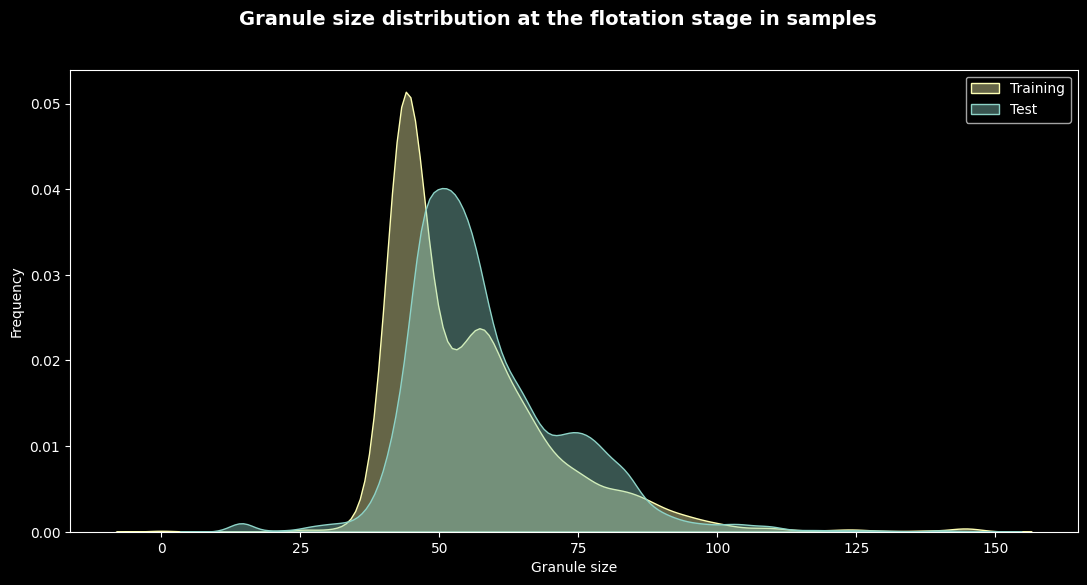

In [17]:
feeds_roug = pd.DataFrame({
    'train': train.loc[train['roug_in_feed_size'] < 150]['roug_in_feed_size'],
    'test': test.loc[test['roug_in_feed_size'] < 150]['roug_in_feed_size']
    })

fig, ax = plt.subplots(figsize=(13,6))
fig.suptitle('Granule size distribution at the flotation stage in samples', fontsize=14, fontweight='bold')
sns.kdeplot(data=feeds_roug, fill=True, common_norm=False, alpha=0.4, ax=ax) 
ax.legend(['Training', 'Test'])
ax.set_xlabel('Granule size')
ax.set_ylabel('Frequency')
plt.show();

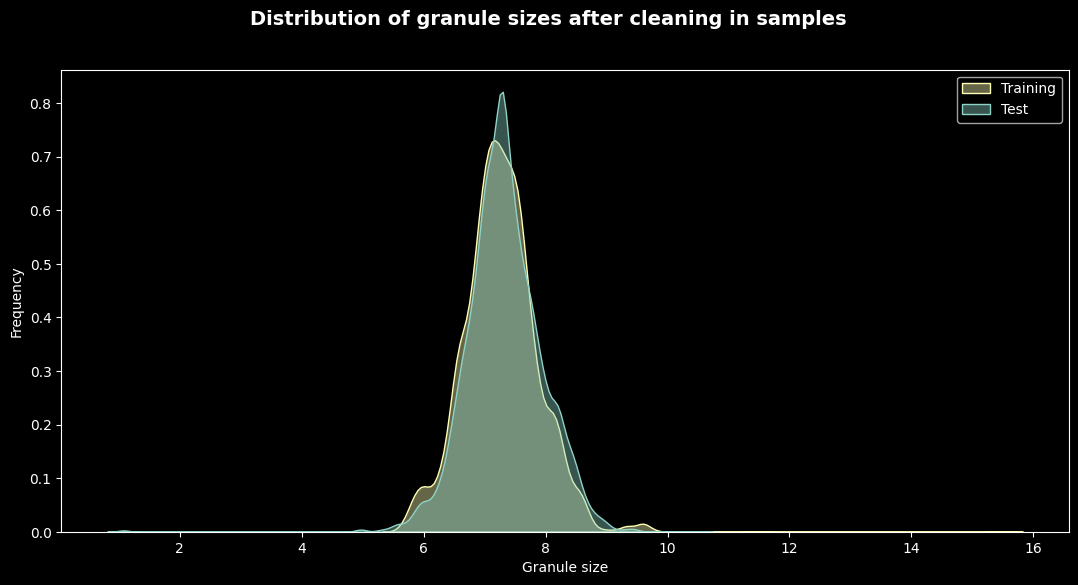

In [18]:
feeds_pr_cl = pd.DataFrame({
    'train': train.loc[train['pr_cl_in_feed_size'] < 150]['pr_cl_in_feed_size'],
    'test': test.loc[test['pr_cl_in_feed_size'] < 150]['pr_cl_in_feed_size']
    })

fig, ax = plt.subplots(figsize=(13,6))
fig.suptitle('Distribution of granule sizes after cleaning in samples', fontsize=14, fontweight='bold')
sns.kdeplot(data=feeds_pr_cl, fill=True, common_norm=False, alpha=0.4, ax=ax) 
ax.legend(['Training', 'Test'])
ax.set_xlabel('Granule size')
ax.set_ylabel('Frequency')
plt.show();

As can be seen on the graph, the distributions almost coincide, the differences are insignificant

### We examine the total concentration of all substances at different stages

In [19]:
train['feed_conc'] = train['roug_in_feed_ag'] + train['roug_in_feed_pb'] + train['roug_in_feed_sol'] + train['roug_in_feed_au']
train['roug_conc'] = train['roug_out_conc_ag'] + train['roug_out_conc_pb'] + train['roug_out_conc_sol'] + train['roug_out_conc_au']
train['fin_conc'] = train['fin_out_conc_ag'] + train['fin_out_conc_pb'] + train['fin_out_conc_sol'] + train['fin_out_conc_au']

In [20]:
met_sum_conc = train[['feed_conc','roug_conc','fin_conc']].groupby(train.index.floor('D')).mean()
# met_sum_conc.iplot(title='The total concentration of all substances at different stages', xTitle='Date', yTitle='Concentration');

<img src="img/total_conc_all_subs_on_stages_by_time.png"
     alt="The total concentration of all substances at different stages by time"
     width="1200"
    >

In some dates, the concentration falls to zero, let's see in histograms

In [21]:
met_sum_conc = train[['feed_conc','roug_conc','fin_conc']]
# met_sum_conc.iplot(kind='hist', title='The total concentration of all substances at different stages', xTitle='Concentration', yTitle='Count');

<img src="img/total_conc_all_subs_on_stages_hist.png"
     alt="The total concentration of all substances at different stages (Histogramm)"
     width="1200"
    >

Conclusion

- the total concentration of substances increases after flotation
- after cleaning, the average value of the concentration of substances remains at the same level, but dispersion decreases and concentration becomes more predictable
- It is necessary to remove the lines with a zero concentration

In [22]:
before_delete = len(train)
train = train.loc[(train['roug_in_feed_au'] > 0) &
                  (train['roug_in_feed_ag'] > 0) & 
                  (train['roug_in_feed_pb'] > 0) & 
                  (train['roug_in_feed_sol'] > 0) & 
                  (train['roug_out_conc_au'] > 0) & 
                  (train['roug_out_conc_ag'] > 0) &
                  (train['roug_out_conc_pb'] > 0) & 
                  (train['roug_out_conc_sol'] > 0) &
                  (train['fin_out_conc_au'] > 0) & 
                  (train['fin_out_conc_ag'] > 0) &
                  (train['fin_out_conc_pb'] > 0) & 
                  (train['fin_out_conc_sol'] > 0)
                 ]
print(f'{before_delete - len(train)} objects deleted')

583 objects deleted


Intermediate conclusion on the block:

- We studied the concentration of metals at different stages and concluded that the concentration of gold increases at each stage, silver is reduced, and the lead increases slightly after the location
- studied the distribution of granules in the samples and concluded that it coincides and will not spoil the results
- values ​​are available in 2/3 years and for the last third (from September to the end of the year) are absent
- the total concentration of substances increases after flotation
- after cleaning, the average value of the concentration of substances remains at the same level, but dispersion decreases and concentration becomes more predictable
- there are emissions up to zero values ​​that we deleted

## Model

### We will write a function for calculating the final sMAPE

Recall the formula from the description

$$ {sMAPE} = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} * 100\% $$

$$ {sMAPE} = 25\% * {sMAPE(rougher)} + 75\% * {sMAPE(final)} $$

In [23]:
def smape(y, y_pred):
    return 1 / len(y) * sum(abs(y - y_pred) / ((abs(y) + abs(y_pred)) / 2)) * 100

def fin_smape(roug_smape, fin_smape):
    return 0.25 * roug_smape + 0.75 * fin_smape

### Learning and Assessment of the quality of models

#### We will divide the dataset to sample

To build a model for predicting efficiency at the flotation stage, we need to use only the parameters associated with this stage.

Let's make a list of these parameters

In [24]:
col_for_roug_model = [col for col in train[col_for_model].columns if col.startswith('roug')]

roug_train_x = train[col_for_roug_model]
roug_train_y = train['roug_out_recovery']
roug_test_x = test[col_for_roug_model]
roug_test_y = full.loc[test.index, 'roug_out_recovery']

fin_train_x = train[col_for_model]
fin_train_y = train['fin_out_recovery']
fin_test_x = test
fin_test_y = full.loc[test.index, 'fin_out_recovery']

if set(roug_train_x) != set(roug_test_x):
    print('Error! The features in the training and test samples for the efficiency calculation model at the flotation stage do not match')
elif set(fin_train_x) != set(fin_test_x):
    print('Error! The features in the training and test samples for the efficiency calculation model do not match')
else:
    print('The features in the training and test samples match')

The features in the training and test samples match


In [25]:
# roug_train_x.iplot(kind='hist', title='Checking Rougher features before model training', xTitle='Value', yTitle='Count');

<img src="img/check_roug_features_met_feed.png"
     alt="Checking Rougher features before model training (feed metall concentration)"
     width="1200"
    >

<img src="img/check_roug_features_rate_and_soze_feed.png"
     alt="Checking Rougher features before model training (feed rate and size)"
     width="1200"
    >

<img src="img/check_roug_features_fb10-11.png"
     alt="Checking Rougher features before model training (feedbank10 &11 parameters)"
     width="1200"
    >

<img src="img/check_roug_features_fb10_air.png"
     alt="Checking Rougher features before model training (feedbank10 air)"
     width="1200"
    >

<img src="img/check_roug_features_fb10_lvl.png"
     alt="Checking Rougher features before model training (feedbank10 level)"
     width="1200"
    >

In [44]:
# fin_train_x.iplot(kind='hist', title='Checking Final features before model training', xTitle='Value', yTitle='Count');

<img src="img/check_fin_cl_in_sulfate.png"
     alt="Checking Final features before model training (input sulfate)"
     width="1200"
    >

<img src="img/check_fin_cl_in.png"
     alt="Checking Final features before model training (input parameters)"
     width="1200"
    >

<img src="img/check_fin_cl_st_fb8_air.png"
     alt="Checking Final features before model training (clear 1, float bank 8 air)"
     width="1200"
    >

<img src="img/check_fin_cl_st_fb8_lvl.png"
     alt="Checking Final features before model training (clear 1, float bank 8 level)"
     width="1200"
    >

<img src="img/check_fin_roug_in_feed_met.png"
     alt="Checking Final features before model training (Rougher input metals)"
     width="1200"
    >

<img src="img/check_fin_roug_in_feed_rate_and_size.png"
     alt="Checking Final features before model training (Rougher input rate & size)"
     width="1200"
    >

<img src="img/check_fin_roug_in_fb10-11.png"
     alt="Checking Final features before model training (Rougher input float bank 10 & 11 sulfate & xanxhatte)"
     width="1200"
    >

<img src="img/check_fin_roug_st_fb10_air.png"
     alt="Checking Final features before model training (Rougher float bank 10 air)"
     width="1200"
    >
    
<img src="img/check_fin_roug_st_fb10_lvl.png"
     alt="Checking Final features before model training (Rougher float bank 10 level)"
     width="1200"
    >

<img src="img/check_fin_sc_fb2-6_a-b_air.png"
     alt="Checking Final features before model training (Clear 2, float bank 2-6 air)"
     width="1200"
    >

<img src="img/check_fin_sc_fb2-6_a-b_lvl.png"
     alt="Checking Final features before model training (Clear 2, float bank 2-6 level)"
     width="1200"
    >

### Create KFold function

We build different models and we want to be sure that each time we work with the equally broken data during a cross. To do this, create a KFold object

In [27]:
kf = KFold(n_splits=5, random_state=1337, shuffle=True)

### Create Scoring Object to use it in ross validation

In [28]:
scor = make_scorer(smape, greater_is_better=False)

## Linear Regression

In [29]:
roug_scaler = StandardScaler()
fin_scaler = StandardScaler()
roug_scaler.fit(roug_train_x)
fin_scaler.fit(fin_train_x)

roug_train_x_scaled = pd.DataFrame(roug_scaler.transform(roug_train_x), columns=col_for_roug_model)
fin_train_x_scaled = pd.DataFrame(fin_scaler.transform(fin_train_x), columns=col_for_model)
roug_test_x_scaled = pd.DataFrame(roug_scaler.transform(roug_test_x), columns=col_for_roug_model)
fin_test_x_scaled = pd.DataFrame(fin_scaler.transform(fin_test_x), columns=col_for_model)

lr_roug_model = LinearRegression()
lr_fin_model = LinearRegression()

lr_roug_smape = cross_val_score(lr_roug_model,
                                roug_train_x_scaled, 
                                roug_train_y, 
                                scoring = scor,
                                cv = kf,
                                n_jobs = -1).mean()

lr_fin_smape = cross_val_score(lr_fin_model, 
                               fin_train_x_scaled,
                               fin_train_y, 
                               scoring = scor,
                               cv = kf,
                               n_jobs = -1).mean()

lr_final_smape = fin_smape(abs(lr_roug_smape), abs(lr_fin_smape))

print('Linear Regression:')
print(f'sMAPE at the flotation stage = {round(abs(lr_roug_smape), 2)}')
print(f'sMAPE at the final stage = {round(abs(lr_fin_smape), 2)}')
print(f'sMAPE = {round(lr_final_smape, 2)}')

Linear Regression:
sMAPE at the flotation stage = 5.18
sMAPE at the final stage = 8.03
sMAPE = 7.32


## RandomForest

To select parameters for next maodel, we will use the RandomizedSearchCV method with grid of this parameters:

In [ ]:
rf_params = {'random_state': [1337],
             'n_estimators': [900, 1000, 1100],
             'max_depth': [20,24],
             'min_samples_split' : [1,2,3],
             'min_samples_leaf' : [1,2,3]
             }

In [36]:
rf_roug_model = RandomForestRegressor()

rf_roug_rndsch = RandomizedSearchCV(rf_roug_model,
                                   param_distributions = rf_params,
                                   n_iter = 10,
                                   scoring = scor,
                                   cv = kf,
                                   random_state = 1337,
                                   n_jobs = -1
                                   )

rf_roug_rndsch.fit(roug_train_x, roug_train_y)

rf_roug_smape = abs(rf_roug_rndsch.best_score_)

print('The best sMAPE value of the random forest model at the stage of raw material preparation for flotation:')
print(rf_roug_smape)
print('with parameters:')
print(rf_roug_rndsch.best_params_)

The best sMAPE value of the random forest model at the stage of raw material preparation for flotation:
2.7019707242847
with parameters:
{'random_state': 1337, 'n_estimators': 1100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 24}


In [39]:
rf_fin_model = RandomForestRegressor()

rf_fin_rndsch = RandomizedSearchCV(rf_fin_model,
                                   param_distributions = rf_params,
                                   n_iter = 10,
                                   scoring = scor,
                                   cv = kf,
                                   random_state = 1337,
                                   n_jobs = -1
                                   )

rf_fin_rndsch.fit(fin_train_x, fin_train_y)

rf_fin_smape = abs(rf_fin_rndsch.best_score_)

print('The best sMAPE value of the random forest model at the stage of raw material preparation for flotation:')
print(rf_fin_smape)
print('with parameters:')
print(rf_fin_rndsch.best_params_)

The best sMAPE value of the random forest model at the stage of raw material preparation for flotation:
5.489161058262947
with parameters:
{'random_state': 1337, 'n_estimators': 1100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 24}


In [40]:
rf_final_smape = fin_smape(rf_roug_smape, rf_fin_smape)

print('RandomForest:')
print(f'sMAPE at the flotation stage = {round(rf_roug_smape, 2)}')
print(f'sMAPE at the final stage = {round(rf_fin_smape, 2)}')
print(f'sMAPE = {round(rf_final_smape, 2)}')

RandomForest:
sMAPE at the flotation stage = 2.7
sMAPE at the final stage = 5.49
sMAPE = 4.79


### Сompare the models

In [45]:
model_names = ['Linear Regression', 
               'Random Forest',  
               ]
             
final_smape = [lr_final_smape,
               rf_final_smape,
               ]

models_dif = pd.DataFrame({'Model':model_names,
                           'sMAPE':final_smape
                           })
models_dif

,Model,sMAPE
0,Linear Regression,7.32
1,Random Forest,4.79


A RandomForest model showed the best sMAPE result

#### Testing the best model

In [42]:
rf_roug_model = RandomForestRegressor(random_state = rf_roug_rndsch.best_params_['random_state'],
                                      n_estimators = rf_roug_rndsch.best_params_['n_estimators'],
                                      min_samples_split = rf_roug_rndsch.best_params_['min_samples_split'],
                                      min_samples_leaf = rf_roug_rndsch.best_params_['min_samples_leaf'],
                                      max_depth = rf_roug_rndsch.best_params_['max_depth'])

rf_fin_model = RandomForestRegressor(random_state = rf_fin_rndsch.best_params_['random_state'],
                                      n_estimators = rf_fin_rndsch.best_params_['n_estimators'],
                                      min_samples_split = rf_fin_rndsch.best_params_['min_samples_split'],
                                      min_samples_leaf = rf_fin_rndsch.best_params_['min_samples_leaf'],
                                      max_depth = rf_fin_rndsch.best_params_['max_depth'])

rf_roug_model.fit(roug_train_x, roug_train_y)
rf_fin_model.fit(fin_train_x, fin_train_y)

rf_roug_pred = rf_roug_model.predict(roug_test_x)
rf_fin_pred = rf_fin_model.predict(fin_test_x)

test_rough_smape = smape(roug_test_y, rf_roug_pred)
test_fin_smape = smape(fin_test_y, rf_fin_pred)
test_final_smape = fin_smape(test_rough_smape, test_fin_smape)

print('RandomForest on test set:')
print(f'sMAPE at the flotation stage = {round(test_rough_smape, 2)}')
print(f'sMAPE at the final stage = {round(test_fin_smape, 2)}')
print(f'sMAPE = {round(test_final_smape, 2)}')

RandomForest on test set:
sMAPE at the flotation stage = 8.02
sMAPE at the final stage = 9.61
sMAPE = 9.22


### Compare with the constant dummy model

In [43]:
dummy_roug_model = DummyRegressor(strategy="median")
dummy_fin_model = DummyRegressor(strategy="median")

dummy_roug_model.fit(roug_train_x, roug_train_y)
dummy_fin_model.fit(fin_train_x, fin_train_y)

dummy_roug_pred = dummy_roug_model.predict(roug_test_x)
dummy_fin_pred = dummy_fin_model.predict(fin_test_x)

dummy_roug_smape = smape(roug_test_y, dummy_roug_pred)
dummy_fin_smape = smape(fin_test_y, dummy_fin_pred)

dummy_final_smape = fin_smape(dummy_roug_smape, dummy_fin_smape)

print('Constant DummyRegressor:')
print(f'sMAPE at the flotation stage = {round(dummy_roug_smape, 2)}')
print(f'sMAPE at the final stage = {round(dummy_fin_smape, 2)}')
print(f'sMAPE = {round(dummy_final_smape, 2)}')

Constant DummyRegressor:
sMAPE at the flotation stage = 8.48
sMAPE at the final stage = 9.69
sMAPE = 9.38


## Conclusion

Work done:
- data loaded and studied
- in the data, the passes are found and removed
- Calculations of the effectiveness of enrichment in the data are verified - compose obtained by the formula
- The signs of a test sample are analyzed and signs that are missing in it are not used in teaching models in the training sample
- the concentration of metals at different stages has been investigated, conclusions were drawn that the concentration of gold grows with each stage, silver falls, and lead grows a little after flotation
- also at this stage an abnormal data in which the concentration of metals is null - these lines are deleted
- the size of the granules in the training and test samples is investigated - the distribution coincides
- Functions for calculating the metrics `sMAPE` are written
- To search for the best model, they used K-FOLD Cross Validation
- The linear regression model is trained.Metric `sMAPE` for ross validation:
    - `sMAPE at the flotation stage` = 5.18
    - `sMAPE at the final stage` = 8.03
    - `sMAPE` = 7.32
- The model of RandomForest is trained. Metric `sMAPE` for ross validation:
    - `sMAPE at the flotation stage` = 2.7
    - `sMAPE at the final stage` = 5.49
    - `sMAPE` = 4.79
- The best model of the trained was a model of random forest. `sMAPE` metric in a test sample:
    - `sMAPE at the flotation stage` = 8.02
    - `sMAPE at the final stage` = 9.61
    - `sMAPE` = 9.22
- The Constant Dummy Model is trained to check our model for adequacy.Her Metric `sMAPE` in a test sample:
    - `sMAPE at the flotation stage` = 8.48
    - `sMAPE at the final stage` = 9.69
    - `sMAPE` = 9.38

Our model shows `sMAPE` better than Dummy model at 0.16